In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### CIFAKE Training and Evaluation

In [3]:
train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Classes:', train_dataset.classes)

Train dataset size: 100000
Test dataset size: 20000
Classes: ['FAKE', 'REAL']


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 56 * 56, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

In [9]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [10]:
for e in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss/len(train_loader))

100%|██████████| 1563/1563 [03:21<00:00,  7.75batch/s, loss=0.131] 


In [11]:
os.makedirs('saved_models', exist_ok=True)
torch.save(model.state_dict(), 'saved_models/cnn_model.pth')

In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, unit="batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 313/313 [04:17<00:00,  1.22batch/s]


In [13]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.8958
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10000
           1       0.89      0.91      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



Confusion matrix:
[[8865 1135]
 [ 949 9051]]


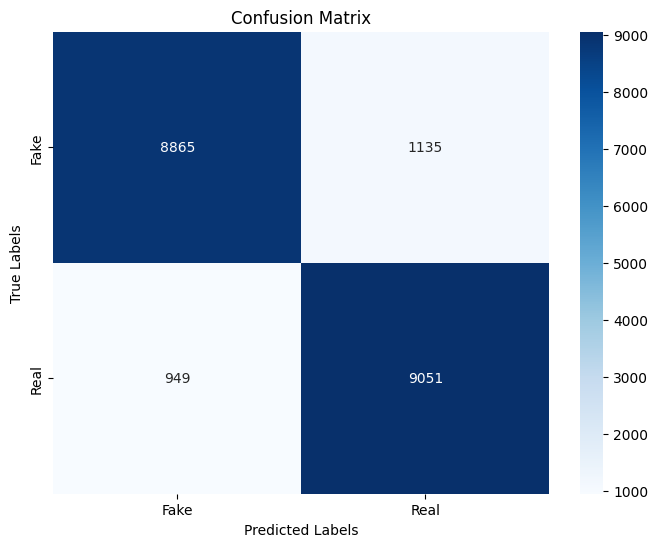

In [14]:
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()

### FakeNet Evaluation

In [3]:
test_dataset = datasets.ImageFolder(root='../FakeNet', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print('Test dataset size:', len(test_dataset))
print('Classes:', test_dataset.classes)

Test dataset size: 9990
Classes: ['FAKE', 'REAL']


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 56 * 56, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

In [6]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Load the model
model.load_state_dict(torch.load('saved_models/cnn_model.pth'))

<All keys matched successfully>

In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, unit="batch"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 157/157 [02:14<00:00,  1.16batch/s]


In [9]:
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy: 0.5001001001001001
Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4990
           1       0.71      0.00      0.00      5000

    accuracy                           0.50      9990
   macro avg       0.61      0.50      0.34      9990
weighted avg       0.61      0.50      0.33      9990



Confusion matrix:
[[4986    4]
 [4990   10]]


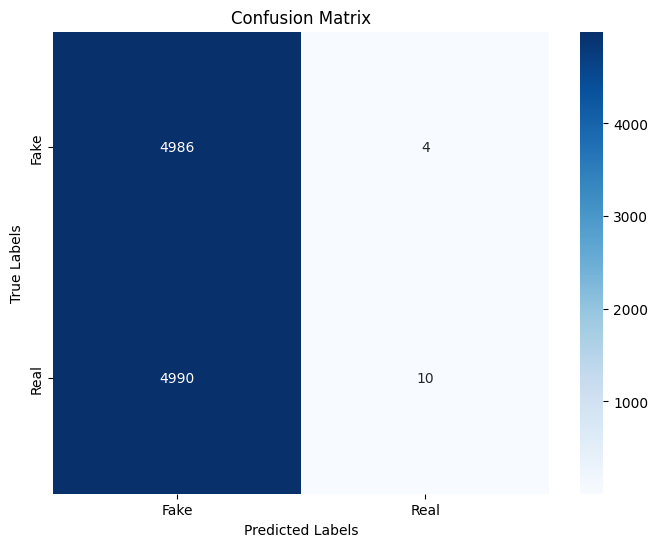

In [10]:
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()